# Establishing Pipelines

## Data separation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Read the data
route_employee_survey = '/content/drive/MyDrive/workplace-engineering-take-home-test-main/src/employee_survey_data.csv'
route_general_data = '/content/drive/MyDrive/workplace-engineering-take-home-test-main/src/general_data.csv'
route_manager_survey = '/content/drive/MyDrive/workplace-engineering-take-home-test-main/src/manager_survey_data.csv'
route_work_logs_data = '/content/drive/MyDrive/workplace-engineering-take-home-test-main/src/work_logs_data.csv'

employee_survey = pd.read_csv(route_employee_survey)
general_data = pd.read_csv(route_general_data)
manager_survey = pd.read_csv(route_manager_survey)
work_logs_data = pd.read_csv(route_work_logs_data, index_col="EmployeeID")

# Merge all data sources into one dataframe
data = employee_survey.merge(general_data, on='EmployeeID')
data = data.merge(manager_survey, on='EmployeeID')

# Drop rows with null values of attrition
data = data.dropna(subset=['Attrition']).set_index('EmployeeID')

# Separate target from predictors
y = data.Attrition
X = data.drop(['Attrition'], axis=1)

# Select numerical columns
columns_numerical = X.select_dtypes(include=[np.number]).columns

# Select categorical columns
columns_categorical = X.select_dtypes(include=["object"]).columns

# For Ordinal Encoding
columns_ordinal = ["BusinessTravel", "MaritalStatus", "Gender", "Over18"]

#For OneHot Encoding
columns_one_hot = columns_categorical.drop(columns_ordinal)

# Select numerical columns except TotalWorkingYears
data_int_cols = columns_numerical.drop("TotalWorkingYears")

# Data Analysis and Figures

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

## Defining Preprocesing steps

### Numerical imputation

Creating a custom transformer for using with TotalWorkingYears column

In [ ]:
from sklearn.impute import SimpleImputer

class WorkingYearsTransformer:
    def __init__(self):
        self.gen_imputer = SimpleImputer(strategy='median')

    def fit(self, X, Y=None):
        self.gen_imputer.fit(X[data_int_cols])

        return self

    def transform(self, df):
        transformed_df = df.copy()

        transformed_df[data_int_cols] = self.gen_imputer.transform(df[data_int_cols])
        transformed_df.loc[transformed_df.TotalWorkingYears.isna(), "TotalWorkingYears"] = transformed_df.loc[transformed_df.TotalWorkingYears.isna(), "YearsAtCompany"]

        return transformed_df


numerical_transformer = WorkingYearsTransformer()

### Categorical imputation and encoding

In [ ]:
# Imputer for categorical columns

cat_imputer = SimpleImputer(strategy='most_frequent')

Preprocessing for categorical Ordinal data

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Encoder for marital and travel
ordinal_encoder_travel = OrdinalEncoder(
    categories=[np.array(['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'])],
    handle_unknown='use_encoded_value',
    unknown_value=-1
    )
ordinal_encoder_marital = OrdinalEncoder(
    categories=[np.array(['Single', 'Married', 'Divorced'])],
    handle_unknown='use_encoded_value',
    unknown_value=-1
    )
ordinal_encoder_18 = OrdinalEncoder(
    categories=[np.array(['N', 'Y'])],
    handle_unknown='use_encoded_value',
    unknown_value=-1
    )

A custom transformer for ordinal categorical data to distinguish between the columns BusinessTravel and MaritalStatus

In [ ]:
class Categorical_Ordinal_Transformer:
    def __init__(self):
        self.temp_imputer = SimpleImputer(strategy='most_frequent')
        self.ordinal_encoder_travel = ordinal_encoder_travel
        self.ordinal_encoder_marital = ordinal_encoder_marital
        self.ordinal_encoder_gender = OrdinalEncoder()
        self.ordinal_encoder_18 = ordinal_encoder_18

    def fit(self, X, Y=None):
        imputed_X = X[columns_ordinal].copy()

        self.temp_imputer.fit(imputed_X)

        imputed_X.iloc[:, :] = self.temp_imputer.transform(imputed_X)

        self.ordinal_encoder_travel.fit(imputed_X[["BusinessTravel"]])
        self.ordinal_encoder_marital.fit(imputed_X[["MaritalStatus"]])
        self.ordinal_encoder_gender.fit(imputed_X[["Gender"]])
        self.ordinal_encoder_18.fit(imputed_X[["Over18"]])

        return self

    def transform(self, df):
        transformed_df = df[columns_ordinal].copy()

        transformed_df.iloc[:, :] = self.temp_imputer.transform(transformed_df)

        transformed_df.loc[:, "BusinessTravel"] = self.ordinal_encoder_travel.transform(transformed_df[["BusinessTravel"]])
        transformed_df.loc[:, "MaritalStatus"] = self.ordinal_encoder_marital.transform(transformed_df[["MaritalStatus"]])
        transformed_df.loc[:, "Gender"] = self.ordinal_encoder_gender.transform(transformed_df[["Gender"]])
        transformed_df.loc[:, "Over18"] = self.ordinal_encoder_18.transform(transformed_df[["Over18"]])

        return transformed_df


categorical_ordinal_transformer = Categorical_Ordinal_Transformer()

Preprocessing for categorical not Ordinal data

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

onehot_encoder = OneHotEncoder(
    handle_unknown='infrequent_if_exist',
    sparse_output=False,
    )

# Complete Pipeline
categorical_oneHot_transformer = Pipeline(steps=[
    ('imputer', cat_imputer),
    ('oneHot', onehot_encoder)
])

Ordinal and OneHot separation

Needed a custom transformer here to manage the loss of the columns for the inner transformer

In [ ]:
class Preprocesor_Transformer:
    def __init__(self):
        self.categorical_ordinal_transformer = categorical_ordinal_transformer
        self.categorical_oneHot_transformer = categorical_oneHot_transformer

    def fit(self, X, Y=None):
        ordinal_df = X[columns_ordinal]
        oneHot_df = X[columns_one_hot]

        self.categorical_ordinal_transformer = self.categorical_ordinal_transformer.fit(ordinal_df)
        self.categorical_oneHot_transformer = self.categorical_oneHot_transformer.fit(oneHot_df)

        return self

    def transform(self, df):
        transformed_df = df.copy()

        transformed_df.loc[:, columns_ordinal] = self.categorical_ordinal_transformer.transform(transformed_df[columns_ordinal])

        hot_encoded_data = self.categorical_oneHot_transformer.transform(transformed_df[columns_one_hot])
        hot_encoded_columns = categorical_oneHot_transformer.get_feature_names_out()

        hot_encoded_df = pd.DataFrame(hot_encoded_data, columns=hot_encoded_columns, index=transformed_df.index)

        transformed_df = pd.concat([transformed_df[columns_ordinal], hot_encoded_df], axis=1)

        return transformed_df


categorical_transformer = Preprocesor_Transformer()

### Categorical and Numerical separation

Same as before

In [ ]:
class Preprocesor_Transformer:
    def __init__(self):
        self.numerical_transformer = numerical_transformer
        self.categorical_transformer = categorical_transformer

    def fit(self, X, Y=None):
        num_df = X[columns_numerical]
        cat_df = X[columns_categorical]

        self.numerical_transformer = self.numerical_transformer.fit(num_df)
        self.categorical_transformer = self.categorical_transformer.fit(cat_df)

        return self

    def transform(self, df):
        num_vals = self.numerical_transformer.transform(df[columns_numerical])
        cat_vals = self.categorical_transformer.transform(df[columns_categorical])

        return np.concatenate((num_vals, cat_vals), axis=1)


preprocessor = Preprocesor_Transformer()

## Multi Variant Analysis

In [ ]:
X.nunique()

EnvironmentSatisfaction       4
JobSatisfaction               4
WorkLifeBalance               4
Age                          43
BusinessTravel                3
Department                    3
DistanceFromHome             29
Education                     5
EducationField                6
EmployeeCount                 1
Gender                        2
JobLevel                      5
JobRole                       9
MaritalStatus                 3
MonthlyIncome              1349
NumCompaniesWorked           10
Over18                        1
PercentSalaryHike            15
StandardHours                 1
StockOptionLevel              4
TotalWorkingYears            40
TrainingTimesLastYear         7
YearsAtCompany               37
YearsSinceLastPromotion      16
YearsWithCurrManager         18
JobInvolvement                4
PerformanceRating             2
dtype: int64

EmployeeCount, Over18 and StandardHours have a single value in all rows, so they are not valid columns for analysis or intelligent models.

### Helpful Functions

#### Functions to get DataFrames with relevant column information

This function returns a DataFrame with the number of rows that appear in each category after grouping 2 columns.

In [ ]:
def countByColumnDF(df, base_col, count_col):
  df_count = df.groupby([count_col, base_col]).size()

  # This line ensures that the response includes the value 0 when there
  # are no rows in a category.
  df_count = df_count.unstack(fill_value=0).stack()

  df_count = pd.DataFrame(df_count, columns=["Count"])

  return df_count

This function returns a DataFrame with the percentage that represent the different values of a column, for each value of another column, after grouping 2 columns.

In [ ]:
def percentageByColumnDF(df, base_col, percentage_col):

  # Using previous function
  df_count = countByColumnDF(df, base_col, percentage_col)

  # This part determines the total counts for each value in the second column.
  df_sum = df_count.reset_index().groupby([percentage_col]).agg(["sum"])
  df_sum = df_sum['Count']
  df_sum.columns = ['Sum']

  # This line calculates the percentage in base 100 for each row of the
  # grouping of the 2 columns.
  return pd.DataFrame((df_count.Count / df_sum.Sum)*100, columns=['Percentage'])

It works similarly to the previous one, but I use it when the second column has continuous values. The function discretizes the continuous values according to the number of points indicated.

In [ ]:
def percentageForContinuousColumnDF(df, base_col, percentage_col, data_points, round=0):
  df_separated = df.copy()

  # Discrete points homogeneously distributed over the range of values are created.
  min = df_separated[percentage_col].min()
  max = df_separated[percentage_col].max()
  labels = np.linspace(min, max, data_points).round(round)

  # The values of the discrete variable are changed by the continuous points established.
  df_separated.loc[:, percentage_col] = pd.cut(df_separated[percentage_col], data_points, labels=labels)

  # Using previous function
  return percentageByColumnDF(df_separated, base_col, percentage_col)

#### Functions for plot data

This function creates a graph with two line subgraphs. The first one to compare the absolute value of a discrete column against different variants. The second shows the percentage value of each at a point.

In [ ]:
def plotDiscreteValuesLine(df, base_col, second_col, figsize=(8, 10), rotation=0, hide_top_label=False):
  # Get the DataFrames for both graphs
  count = countByColumnDF(df, base_col, second_col).reset_index()
  prcnt = percentageByColumnDF(df, base_col, second_col).reset_index()

  # Create the 2 subplots
  fig, axes = plt.subplots(2, 1, figsize=figsize)

  fig.suptitle(f'Attrition Data of People in the Organization by {second_col}')

  # Plot both graphs using the data
  sns.lineplot(ax=axes[0], data=count, x=second_col, y='Count', hue=base_col)
  axes[0].set_title('Counts')
  sns.lineplot(ax=axes[1], data=prcnt, x=second_col, y='Percentage', hue=base_col)
  axes[1].set_title('Percentage')

  # If necesary, shows only the bottom X labels and rotate them.
  if hide_top_label:
    axes[0].set_xticklabels([])
  else:
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)

  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)

Same as before but with bars graphs.

In [ ]:
def plotDiscreteValuesBar(df, base_col, second_col, figsize=(8, 10), rotation=0, hide_top_label=False):
  # Get the DataFrames for both graphs
  count = countByColumnDF(df, base_col, second_col).reset_index()
  prcnt = percentageByColumnDF(df, base_col, second_col).reset_index()

  # Create the 2 subplots
  fig, axes = plt.subplots(2, 1, figsize=figsize)

  fig.suptitle(f'Attrition Data of People in the Organization by {second_col}')

  # Plot both graphs using the data
  sns.barplot(ax=axes[0], data=count, x=second_col, y='Count', hue=base_col)
  axes[0].set_title('Counts')
  sns.barplot(ax=axes[1], data=prcnt, x=second_col, y='Percentage', hue=base_col)
  axes[1].set_title('Percentage')

  # If necesary, shows only the bottom X labels and rotate them.
  if hide_top_label:
    axes[0].set_xticklabels([])
  else:
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)

  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)

Similar to the previous ones but using Kernel Density Estimation (KDE) to handle the continuous values of the data.

In [ ]:
def plotContinuousValuesKDE(df, base_col, second_col, data_points, round=0):
  # Get the DataFrames for both graphs
  plot_data = df[[second_col, base_col]].sort_values(by=second_col, ascending=True)
  plot_data_2 = percentageForContinuousColumnDF(df, base_col, second_col, data_points, round).reset_index()

  # Change the second DataFrame dtype into a continuous one
  plot_data_2[second_col] = plot_data_2[second_col].astype("float64")

  # Create the 2 subplots
  fig, axes = plt.subplots(2, 1, figsize=(8, 10))

  fig.suptitle(f'Attrition Data of People in the Organization by {second_col}')

  # Plot both graphs using the data
  sns.kdeplot(ax=axes[0], data=plot_data, x=second_col, hue=base_col, fill=True, alpha=0.6, linewidth=1.5)
  axes[0].set_title('Counts')
  sns.kdeplot(ax=axes[1], data=plot_data_2, x=second_col, y='Percentage', hue=base_col)
  axes[1].set_title('Percentage')

### Numerical Data

Imputes null values and includes Attrition in the DataFrame.

In [ ]:
numerical_transformer.fit(X[columns_numerical])
imputed_numerical = numerical_transformer.transform(X[columns_numerical])

data_analysis_numerical = pd.DataFrame(y).merge(imputed_numerical, on='EmployeeID')

####  Age

<ipython-input-14-3431c8b66194>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-14-3431c8b66194>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


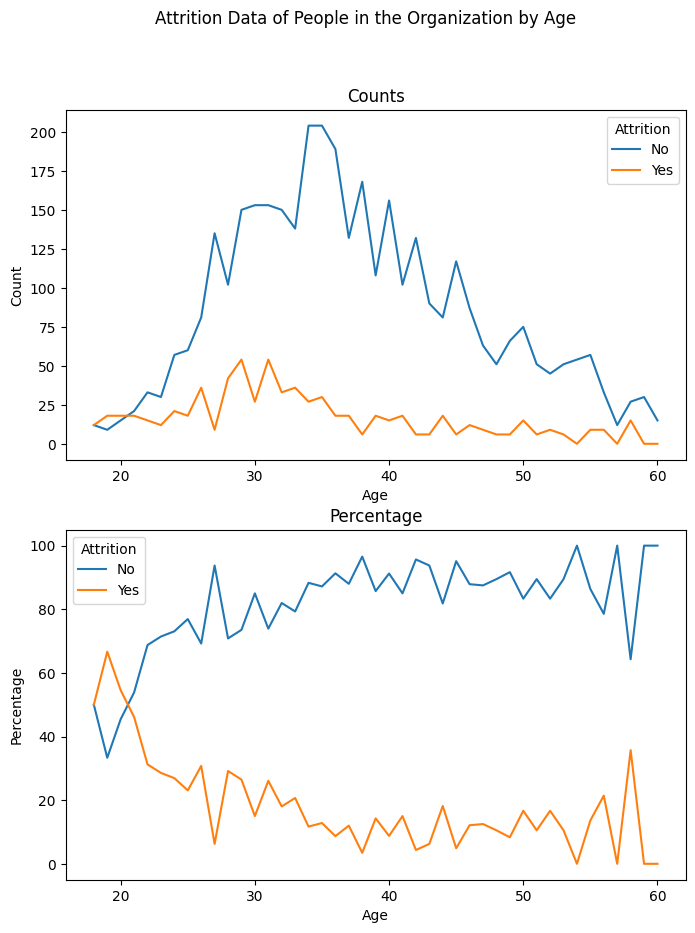

In [ ]:
base_col = "Attrition"
second_col = "Age"

plotDiscreteValuesLine(data_analysis_numerical, base_col, second_col)

The first graph shows how the majority of employees are in the 25 to 50 age group.
The second shows that the majority of attritions occur among younger employees, under 20 years of age, and that this decreases with increasing age, with a peak at around 60 years of age.
This behavior is probably due to the fact that young people tend to explore various job options before settling in and older people tend to retire.

#### Distance From Home

<ipython-input-14-3431c8b66194>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-14-3431c8b66194>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


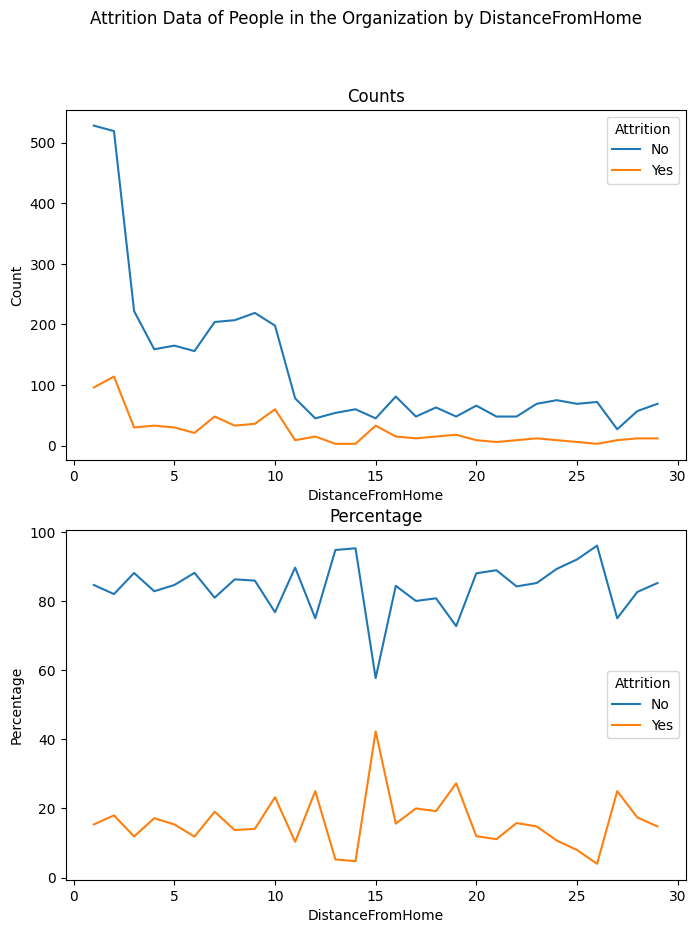

In [ ]:
base_col = "Attrition"
second_col = "DistanceFromHome"

plotDiscreteValuesLine(data_analysis_numerical, base_col, second_col)

The first graph shows how the majority of employees live close to work.  The second graph does not show much variation in attrition, except for a peak at the 15km value.

#### Education

<ipython-input-15-cc56d3b3d150>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-15-cc56d3b3d150>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


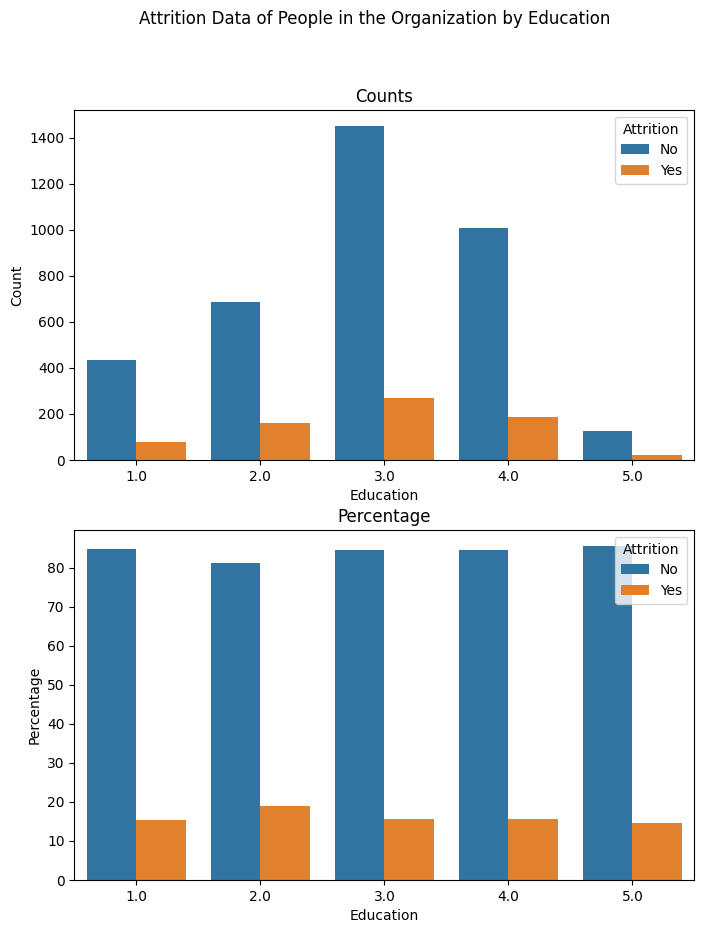

In [ ]:
base_col = "Attrition"
second_col = "Education"

plotDiscreteValuesBar(data_analysis_numerical, base_col, second_col)

The first graph shows how the majority of employees have a Bachelor's or Master's degree.  The second graph does not show much variation in attrition, except for a very small peak in College values.

#### Environment Satisfaction

<ipython-input-15-cc56d3b3d150>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-15-cc56d3b3d150>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


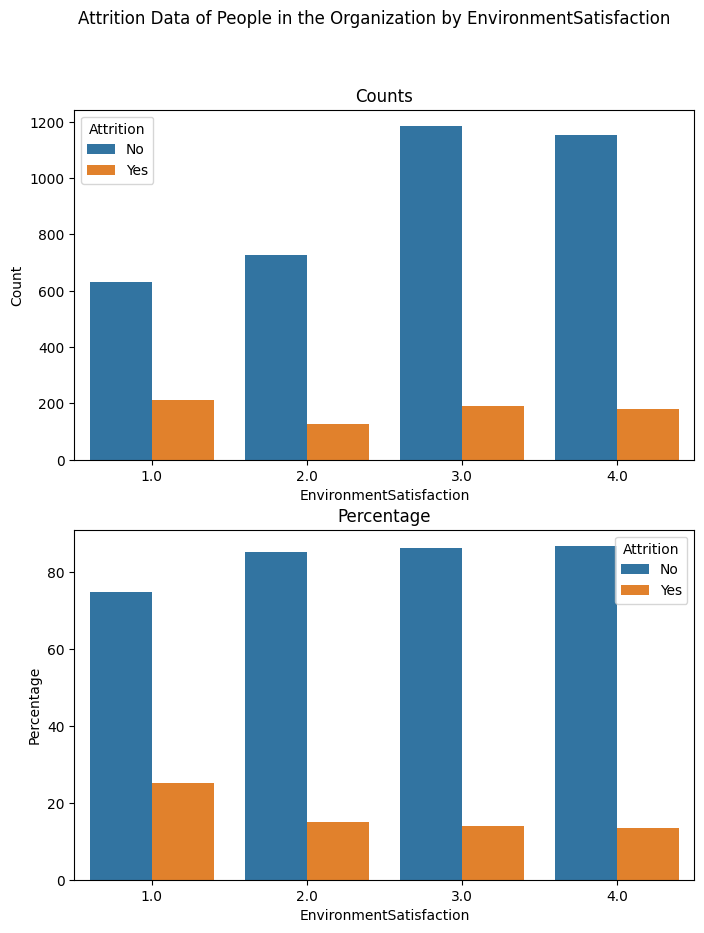

In [ ]:
base_col = "Attrition"
second_col = "EnvironmentSatisfaction"

plotDiscreteValuesBar(data_analysis_numerical, base_col, second_col)

The first graph shows how most employees are satisfied with their work environment. The second graph does not show much variation in attrition, except for a small peak in the lowest satisfaction value.

#### Job Level

<ipython-input-15-cc56d3b3d150>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-15-cc56d3b3d150>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


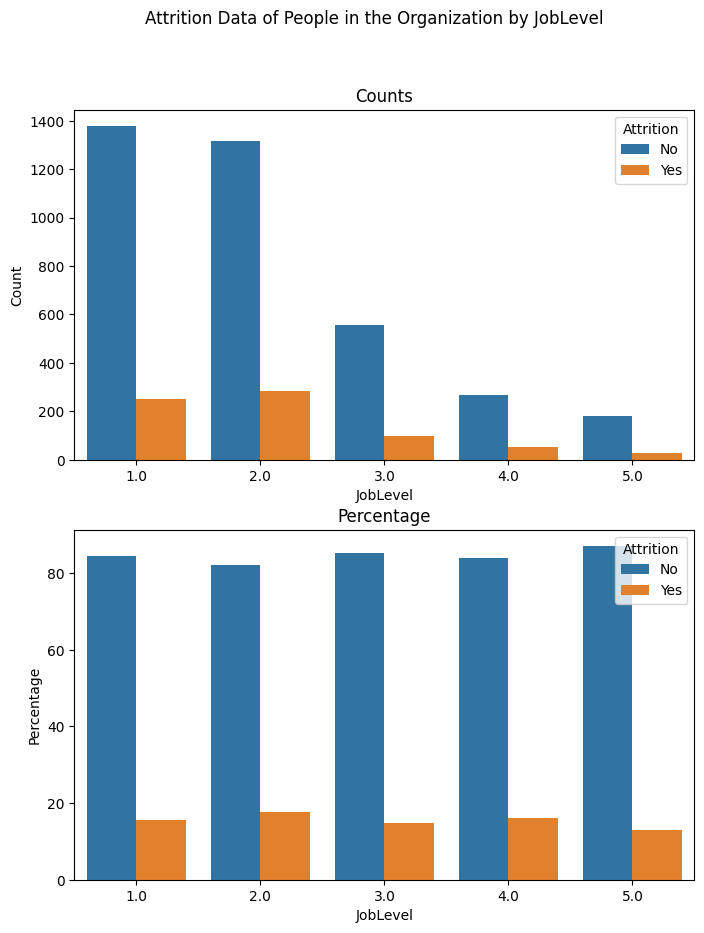

In [ ]:
base_col = "Attrition"
second_col = "JobLevel"

plotDiscreteValuesBar(data_analysis_numerical, base_col, second_col)

The first graph shows how the majority of employees are in the first two levels. The second graph does not show much variation in attrition.

#### Job Satisfaction

<ipython-input-15-cc56d3b3d150>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-15-cc56d3b3d150>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


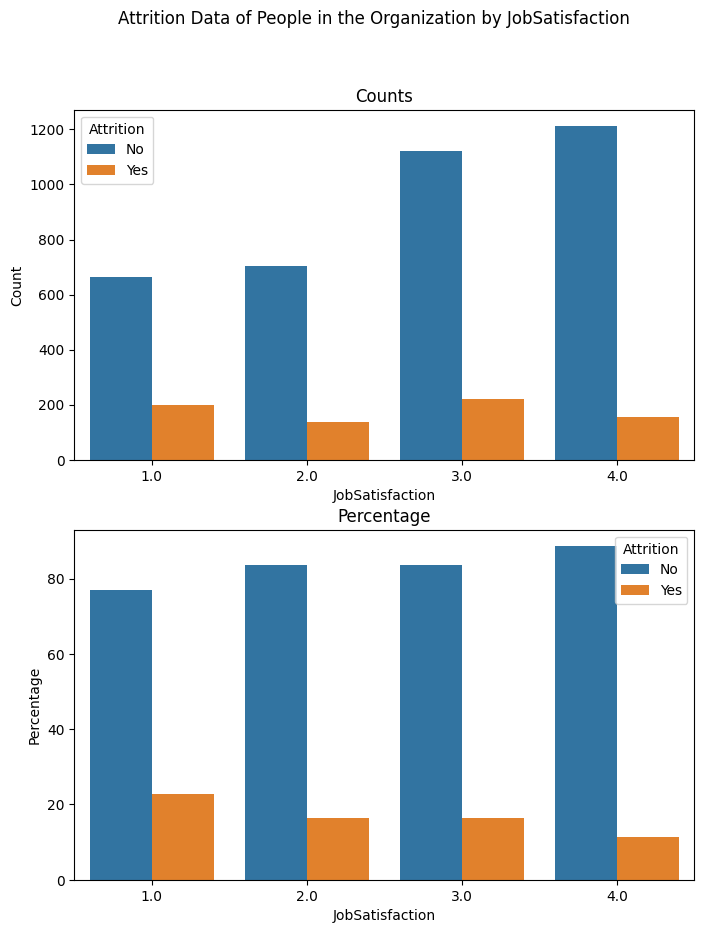

In [ ]:
base_col = "Attrition"
second_col = "JobSatisfaction"

plotDiscreteValuesBar(data_analysis_numerical, base_col, second_col)

The first graph shows how most employees are satisfied with their work, but the difference is not very large. Meanwhile, the second graph shows a slight increase in attrition at the minimum level and a slight decrease in attrition at the maximum level, indicating that workers remain in jobs in which they are satisfied.

#### Number Companies Worked

<ipython-input-14-3431c8b66194>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-14-3431c8b66194>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


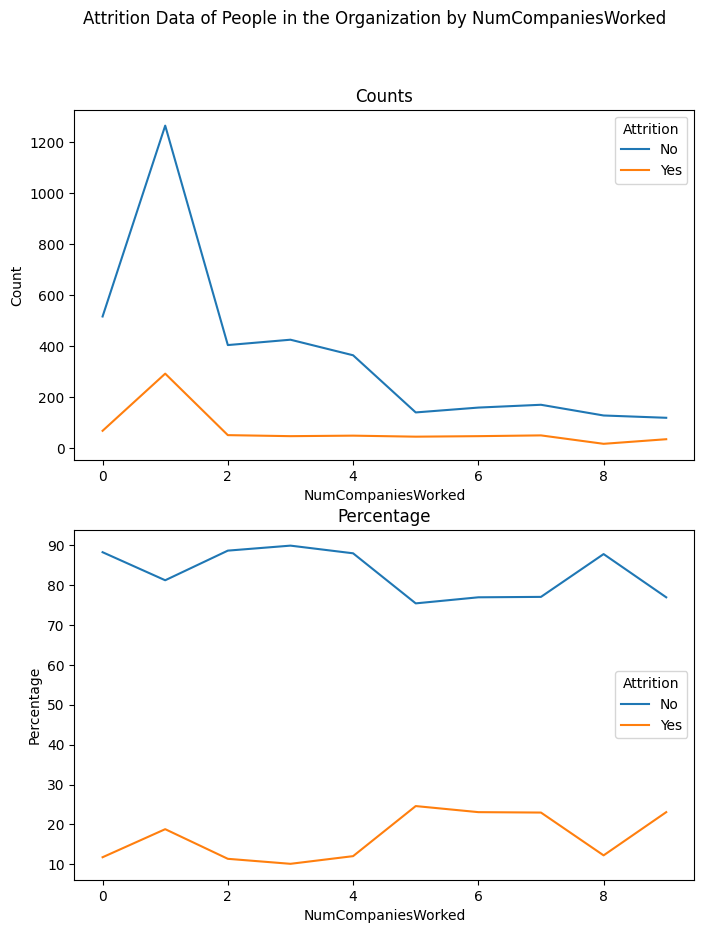

In [ ]:
base_col = "Attrition"
second_col = "NumCompaniesWorked"

plotDiscreteValuesLine(data_analysis_numerical, base_col, second_col)

The first graph shows how having worked in only one company is the common value. The second graph shows small peaks of attrition at values 1, 5 to 7, and 9, so that no clear relationship can be determined.

#### Percent Salary Hike

<ipython-input-14-3431c8b66194>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-14-3431c8b66194>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


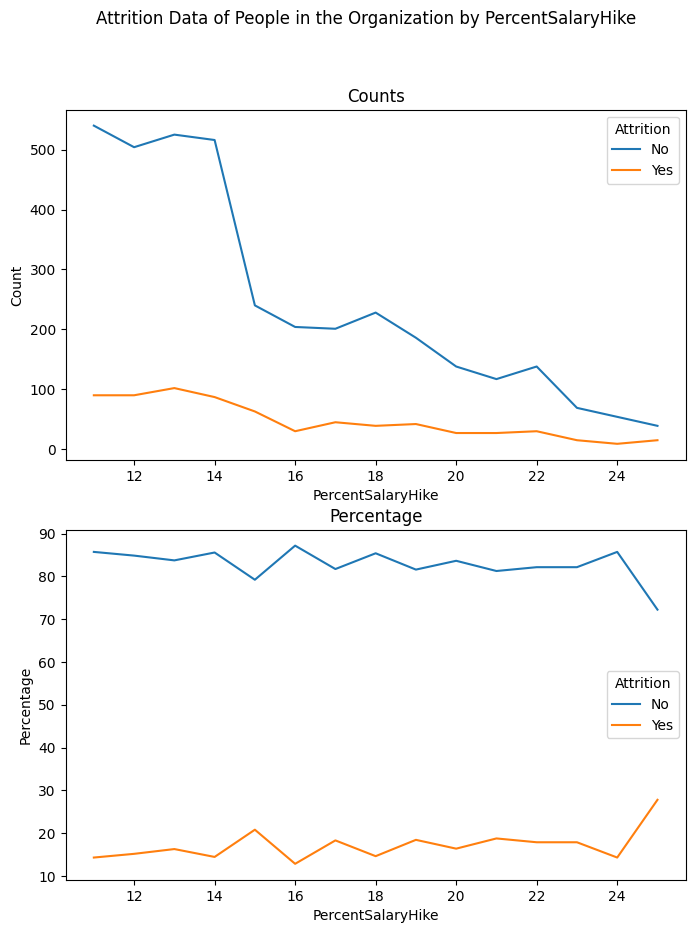

In [ ]:
base_col = "Attrition"
second_col = "PercentSalaryHike"

plotDiscreteValuesLine(data_analysis_numerical, base_col, second_col)

The first graph shows that the most common increase for employees was between 11% and 14%. The second graph shows a relatively constant value of attrition, with a peak at the 25% increase value, which could indicate that employees with a large salary increase tend to seek higher positions in the labor market.

#### Stock Option Level

<ipython-input-15-cc56d3b3d150>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-15-cc56d3b3d150>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


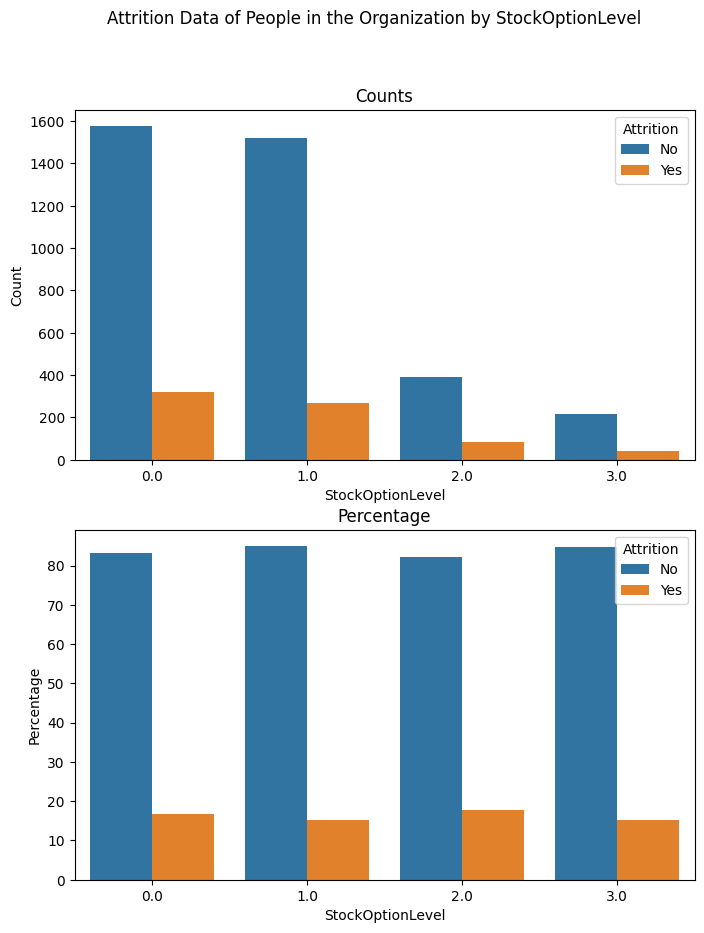

In [ ]:
base_col = "Attrition"
second_col = "StockOptionLevel"

plotDiscreteValuesBar(data_analysis_numerical, base_col, second_col)

The first graph shows that most employees are at level 0 or 1. The second graph shows a relatively constant value of attrition.

#### Total Working Years

<ipython-input-14-3431c8b66194>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-14-3431c8b66194>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


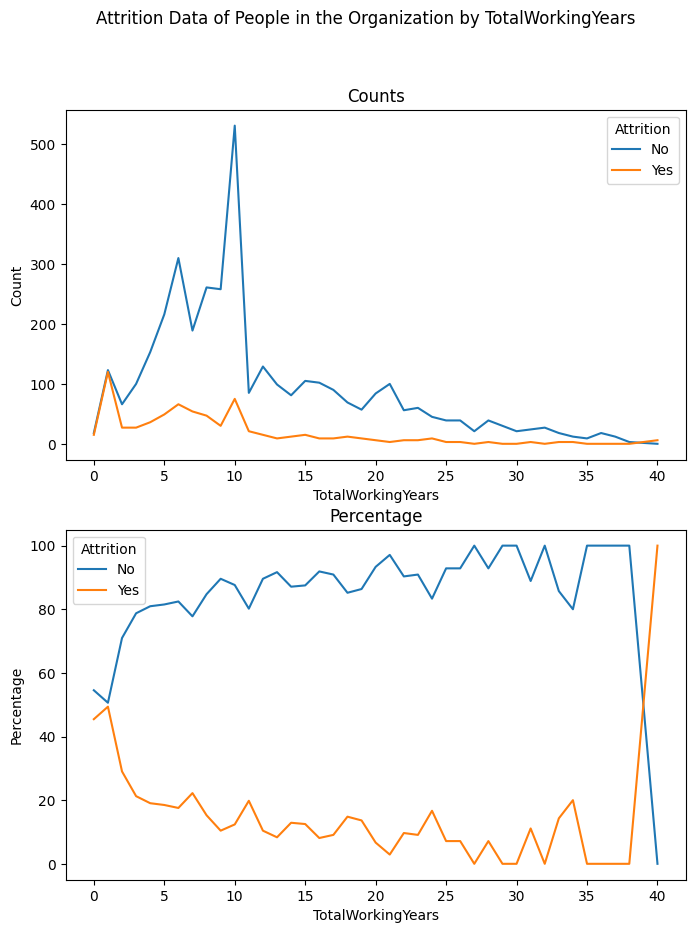

In [ ]:
base_col = "Attrition"
second_col = "TotalWorkingYears"

plotDiscreteValuesLine(data_analysis_numerical, base_col, second_col)

The first graph shows how the most common value of employees' years worked is between 5 and 10 years. The second shows that most attrition occurs among employees with less than 3 years of work, and that this decreases as the number of years increases, with a small peak at years 33 and 34 and a large peak at year 40. This behavior is probably due to the fact that people starting to work tend to explore several job options before settling down and older people tend to retire.

#### Training Times Last Year

<ipython-input-14-3431c8b66194>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-14-3431c8b66194>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


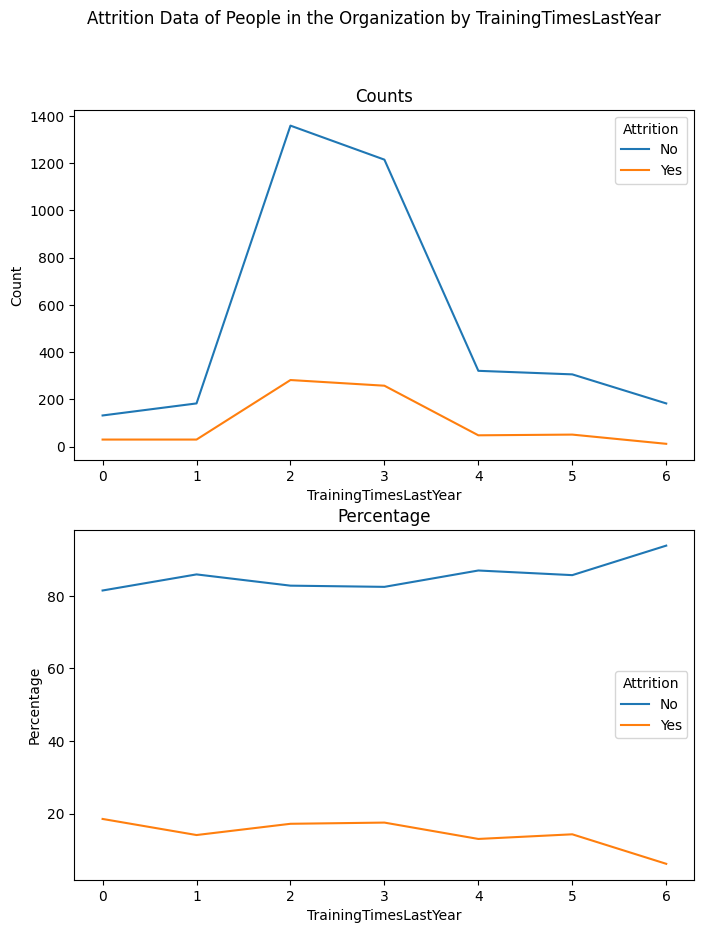

In [ ]:
base_col = "Attrition"
second_col = "TrainingTimesLastYear"

plotDiscreteValuesLine(data_analysis_numerical, base_col, second_col)

The first graph shows how most employees had 2 or 3 trainings in the year. The second shows that attrition remains constant, with a small decrease in employees who had 6 trainings.

#### Years At Company

<ipython-input-14-3431c8b66194>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-14-3431c8b66194>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


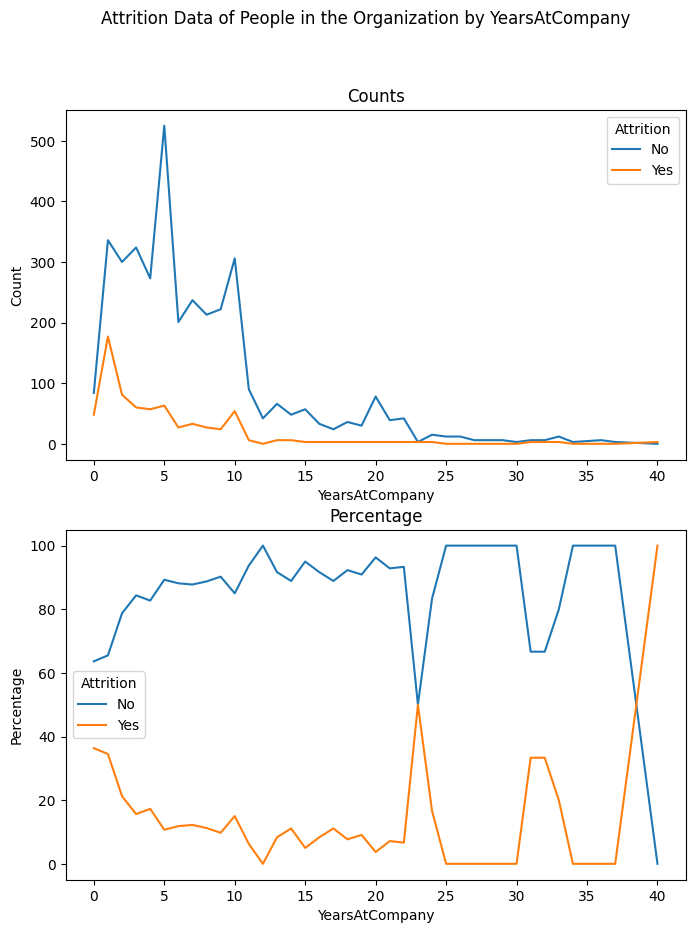

In [ ]:
base_col = "Attrition"
second_col = "YearsAtCompany"

plotDiscreteValuesLine(data_analysis_numerical, base_col, second_col)

The first graph shows how the most common value of years in the company for employees is between 1 and 10 years. The second shows that most departures occur among employees with less than 3 years of employment, and that this decreases as the number of years increases, with peaks at years 23, 31 and 32 and a large peak at year 40. This behavior is probably due to the fact that people who start working have a process where they adapt and decide to stay and older people tend to retire. I do not know the reason for the peak at year 23, so further research is needed.

#### Years Since Last Promotion

<ipython-input-14-3431c8b66194>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-14-3431c8b66194>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


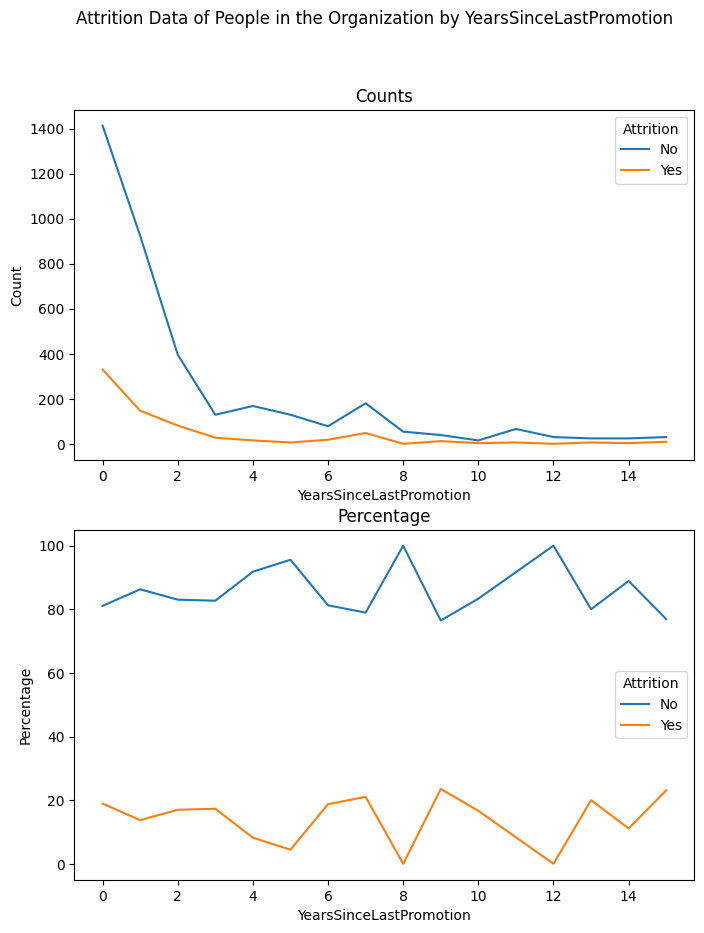

In [ ]:
base_col = "Attrition"
second_col = "YearsSinceLastPromotion"

plotDiscreteValuesLine(data_analysis_numerical, base_col, second_col)

The first graph shows how it is most common that less than 2 years have passed since the employees' last promotion. The second shows that attrition behaves erratically, without being too time-dependent.

#### Years With Current Manager

<ipython-input-14-3431c8b66194>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-14-3431c8b66194>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


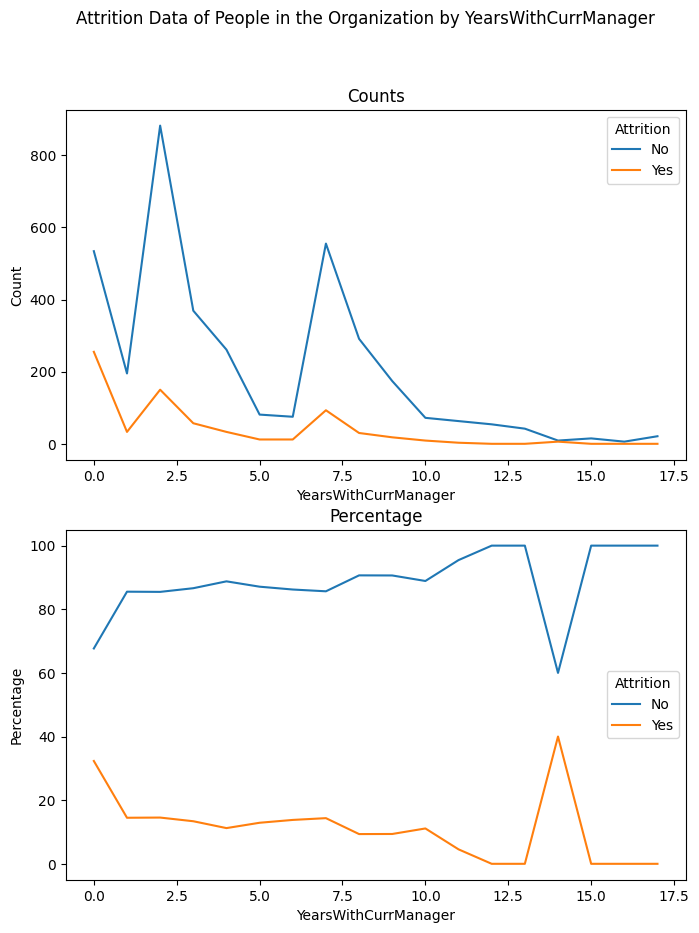

In [ ]:
base_col = "Attrition"
second_col = "YearsWithCurrManager"

plotDiscreteValuesLine(data_analysis_numerical, base_col, second_col)

The first graph shows how the most common values of years with the employees' current manager are 0, 2.5 and 7.5 years. The second shows that most departures occur among employees with a new manager, and that this decreases as the number of years increases, with a peak at 14 years. This behavior is probably due to the fact that the starting point includes new workers, who have already been shown to have a high probability of leaving. In addition, a new manager may be a reason for the departure of some workers due to a change in management policies. I don't know what the spike in the 14 years is due to.

#### Job Involvement

<ipython-input-15-cc56d3b3d150>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-15-cc56d3b3d150>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


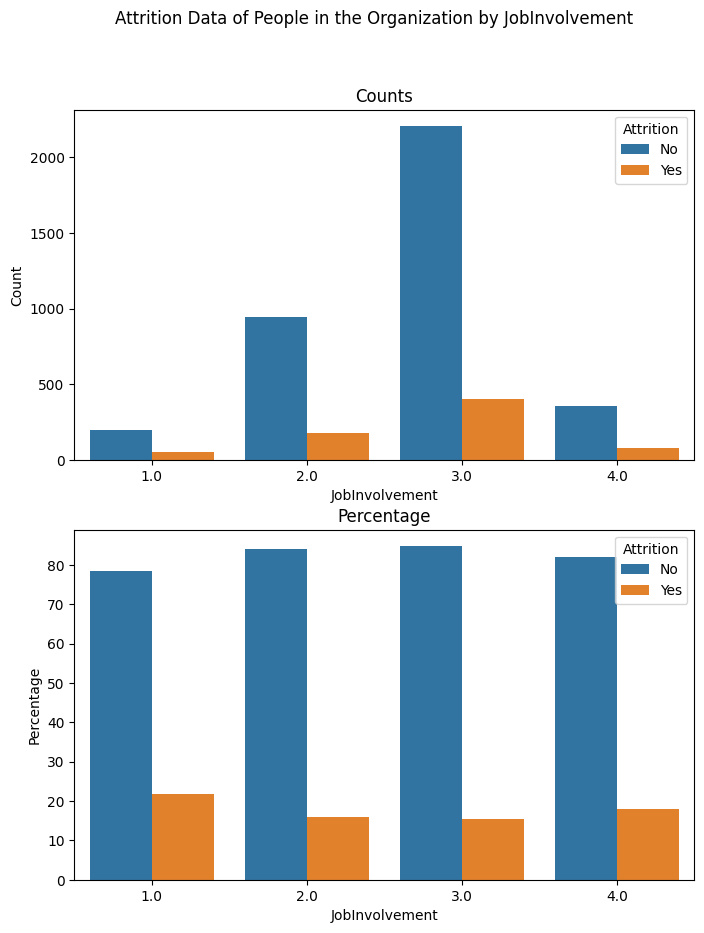

In [ ]:
base_col = "Attrition"
second_col = "JobInvolvement"

plotDiscreteValuesBar(data_analysis_numerical, base_col, second_col)

The first graph shows how most employees have a good value of job involvement. The second graph shows a small increase in attrition for employees with the minimum job involvement value.

#### Performance Rating

<ipython-input-15-cc56d3b3d150>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-15-cc56d3b3d150>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


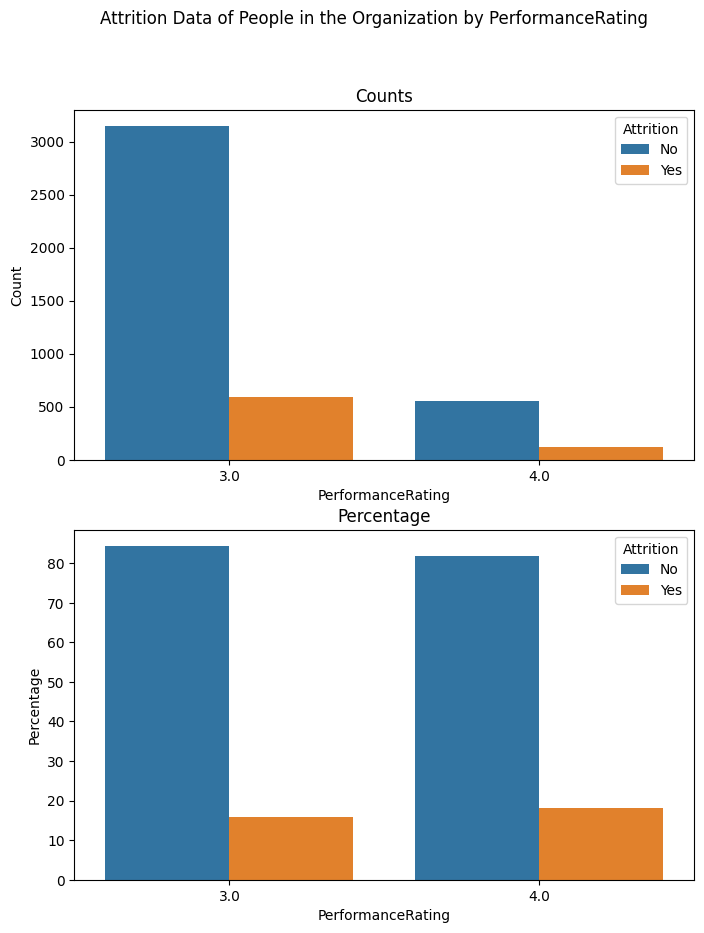

In [ ]:
base_col = "Attrition"
second_col = "PerformanceRating"

plotDiscreteValuesBar(data_analysis_numerical, base_col, second_col)

The first graph shows that all employees have a good performance rating. The second shows that there is no visible dependence between this and attrition.

#### Work Life Balance

<ipython-input-15-cc56d3b3d150>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-15-cc56d3b3d150>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


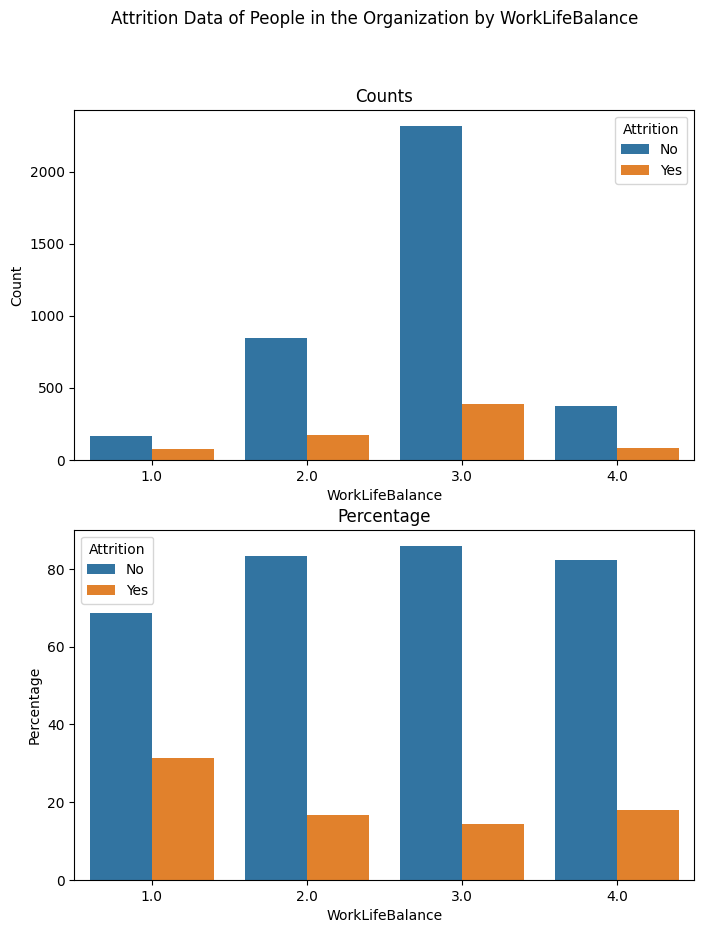

In [ ]:
base_col = "Attrition"
second_col = "WorkLifeBalance"

plotDiscreteValuesBar(data_analysis_numerical, base_col, second_col)

The first graph shows that most employees have a good work-life balance. The second shows that employees with a low level of work-life balance are more likely to attrition. In addition, a small increase in the probability of leaving is observed for employees with a maximum level of work-life balance.

#### Monthly Income

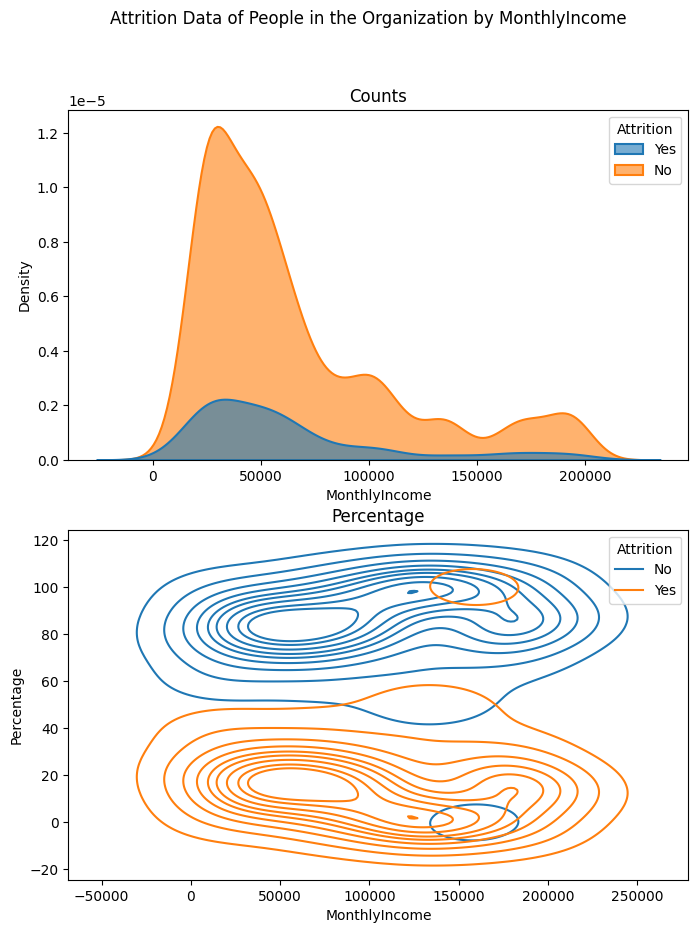

In [ ]:
base_col = "Attrition"
second_col = "MonthlyIncome"
data_points = 100
round = 2

plotContinuousValuesKDE(data_analysis_numerical, base_col, second_col, data_points, round)

The first graph shows how most employees earn less than Rs. 9000 per month. The second shows that most attrition occurs among employees with a lower salary, and that this decreases as the salary increases, with a peak rise at Rs. 15000. This behavior is probably due to the fact that a low salary is an important incentive to change jobs. The peak at Rs. 15,000 is likely due to a change in the worker's quality of life, which leads him or her to seek new, better-paying options.

### Categorical Data

Imputes null values and includes Attrition in the DataFrame.

In [ ]:
imputed_categorical = X[columns_categorical].copy()

cat_imputer.fit(imputed_categorical)
imputed_categorical.loc[:, :] = cat_imputer.transform(imputed_categorical)

data_analysis_categorical = pd.DataFrame(y).merge(imputed_categorical, on='EmployeeID')

#### Business Travel

<ipython-input-15-cc56d3b3d150>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-15-cc56d3b3d150>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


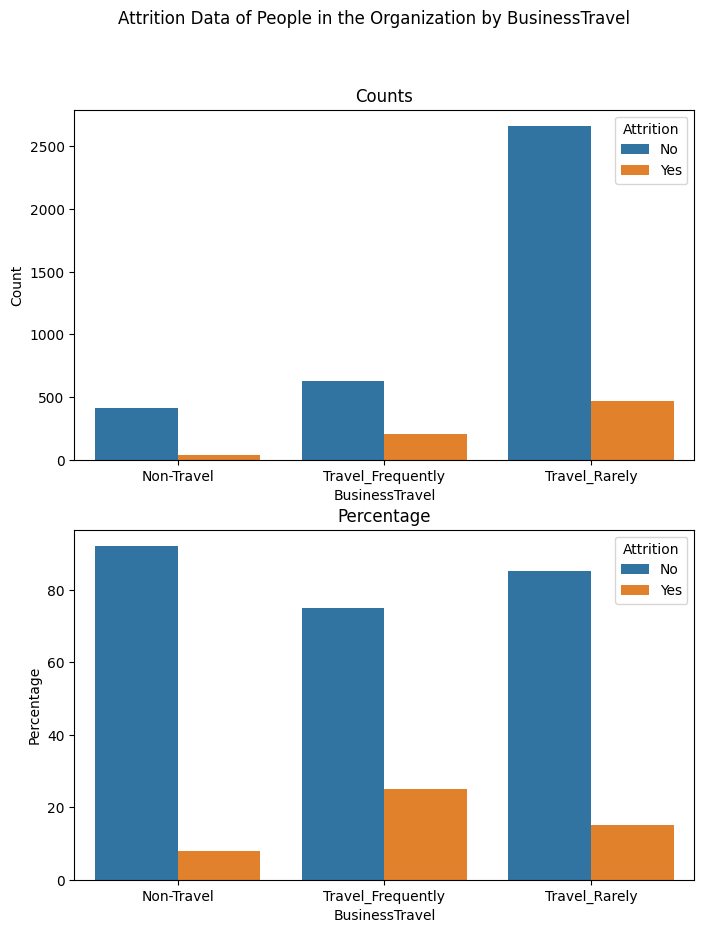

In [ ]:
base_col = "Attrition"
second_col = "BusinessTravel"

plotDiscreteValuesBar(data_analysis_categorical, base_col, second_col)

The first graph shows that most employees travel rarely. The second shows that employees who do not travel have the lowest attrition value and those who travel frequently have the highest value. This seems to indicate that employees prefer to avoid business travel.

#### Department

<ipython-input-15-cc56d3b3d150>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-15-cc56d3b3d150>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


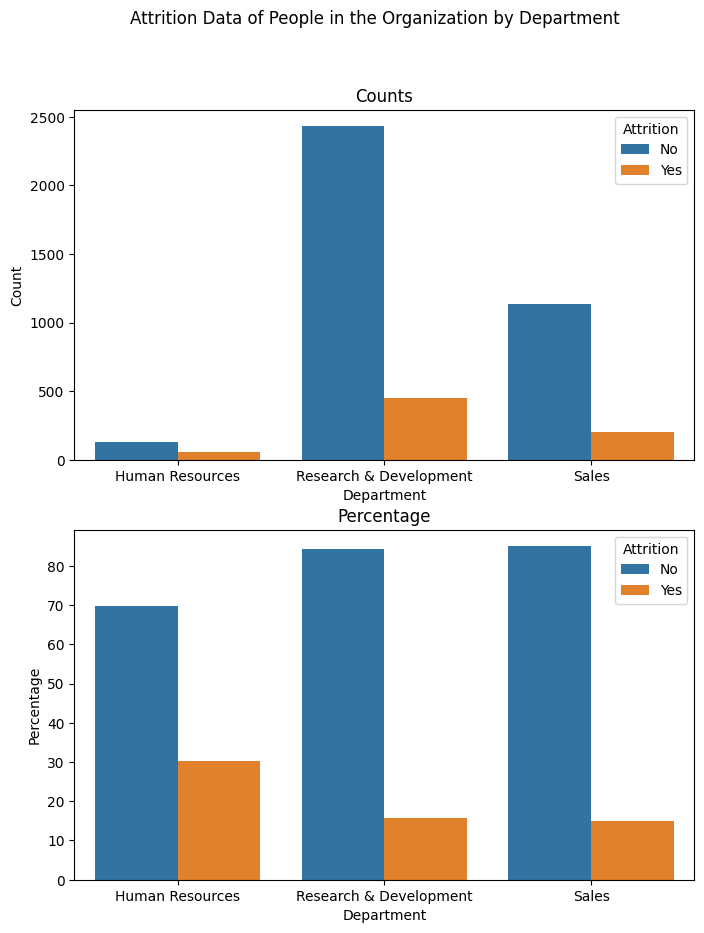

In [ ]:
base_col = "Attrition"
second_col = "Department"

plotDiscreteValuesBar(data_analysis_categorical, base_col, second_col)

The first graph shows that the majority of employees work in Research and Development or Sales. The second graph shows that Human Resources employees have the highest attrition rates, while the other two have similar percentages to each other. This seems to indicate that there is a worse work environment in the Human Resources department than in the others.

#### Education Field

<ipython-input-15-cc56d3b3d150>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-15-cc56d3b3d150>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


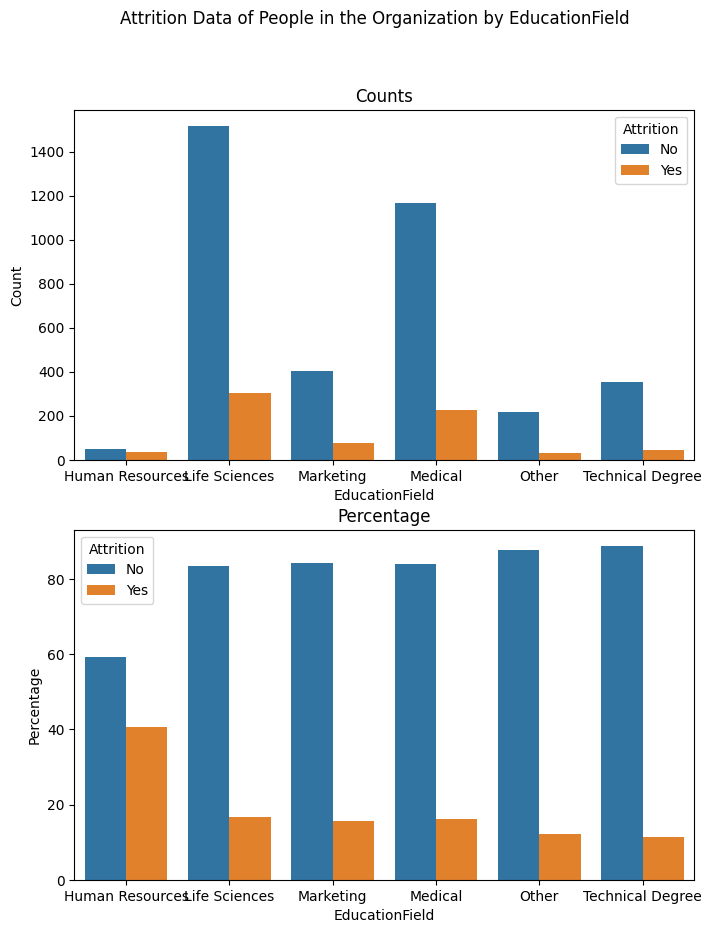

In [ ]:
base_col = "Attrition"
second_col = "EducationField"

plotDiscreteValuesBar(data_analysis_categorical, base_col, second_col)

The first chart shows that the majority of employees studied Life Sciences or Medical Sciences. The second chart shows that employees who studied Human Resources have the highest attrition rates, which corresponds with the previous result. The other fields have similar percentages to each other.

#### Gender

<ipython-input-15-cc56d3b3d150>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-15-cc56d3b3d150>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


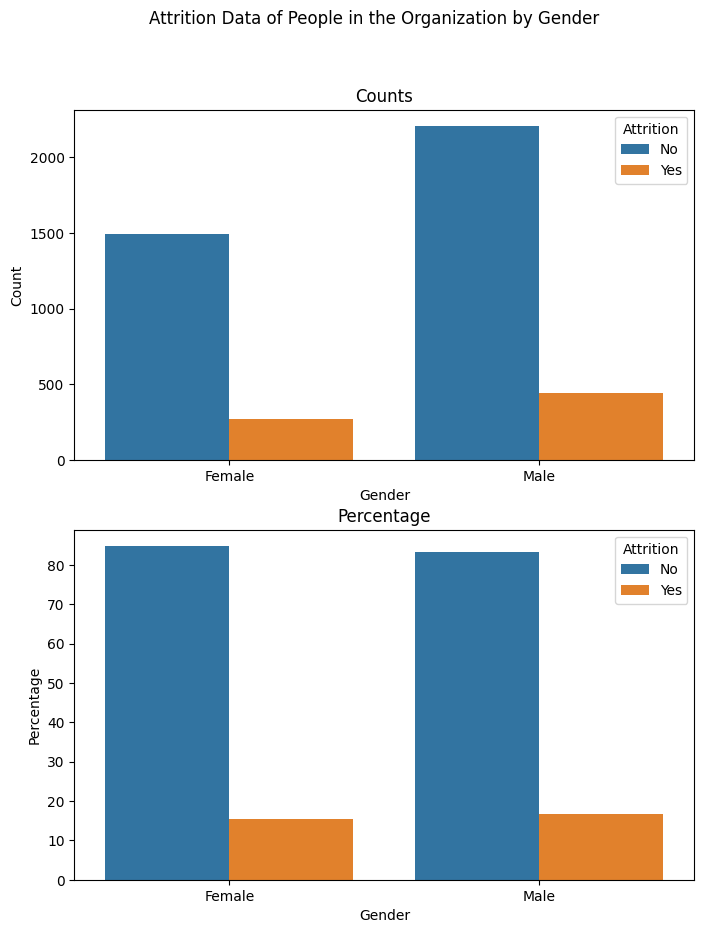

In [ ]:
base_col = "Attrition"
second_col = "Gender"

plotDiscreteValuesBar(data_analysis_categorical, base_col, second_col)

The first chart shows that there are more male employees than female employees. The second chart shows that gender does not significantly influence attrition.

#### Job Role

<ipython-input-14-3431c8b66194>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


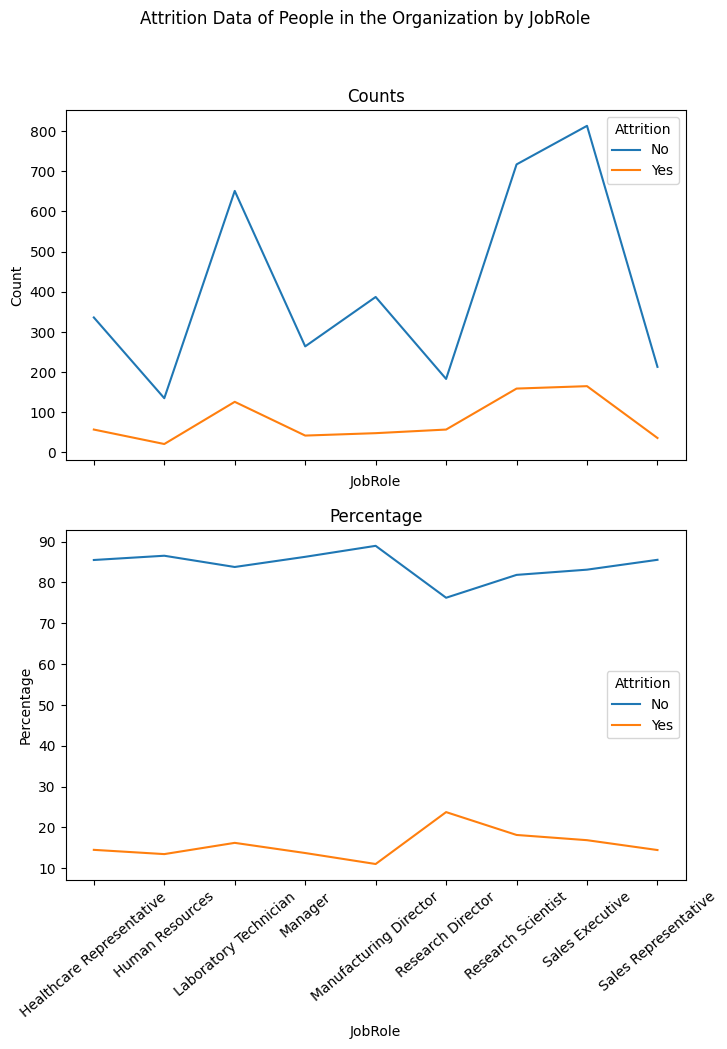

In [ ]:
base_col = "Attrition"
second_col = "JobRole"
rotation = 40
hide_top_label = True

plotDiscreteValuesLine(data_analysis_categorical, base_col, second_col,
                       rotation=rotation, hide_top_label=hide_top_label)

The first chart shows that the most common roles are: Laboratory Technician, Development Scientist, and Sales Executive. The second chart shows that there are no significant differences in attrition, except for a small peak among Development Directors.

#### Marital Status

<ipython-input-15-cc56d3b3d150>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-15-cc56d3b3d150>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


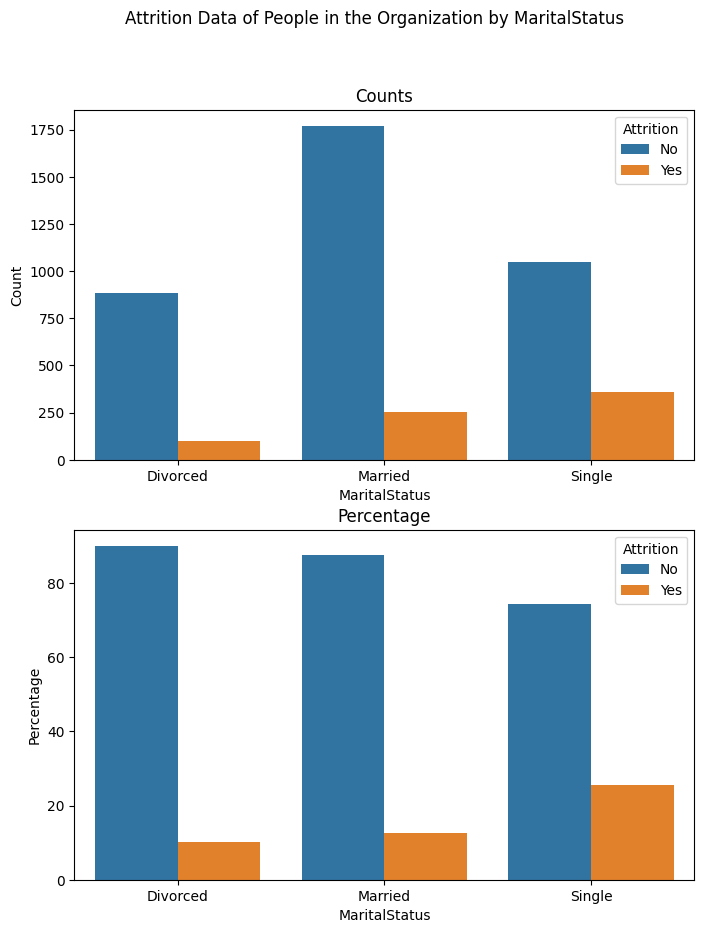

In [ ]:
base_col = "Attrition"
second_col = "MaritalStatus"

plotDiscreteValuesBar(data_analysis_categorical, base_col, second_col)

The first chart shows that the most common marital status among employees is married. The second chart shows that single employees have the highest attrition rates, while the other two have similar percentages. This may be because single employees have more freedom with fewer family responsibilities.

### Work Logs Data

Includes Attrition in the DataFrame.

In [ ]:
data_analysis_logs = pd.DataFrame(y).merge(work_logs_data, on='EmployeeID')

#### Prom Hours Day

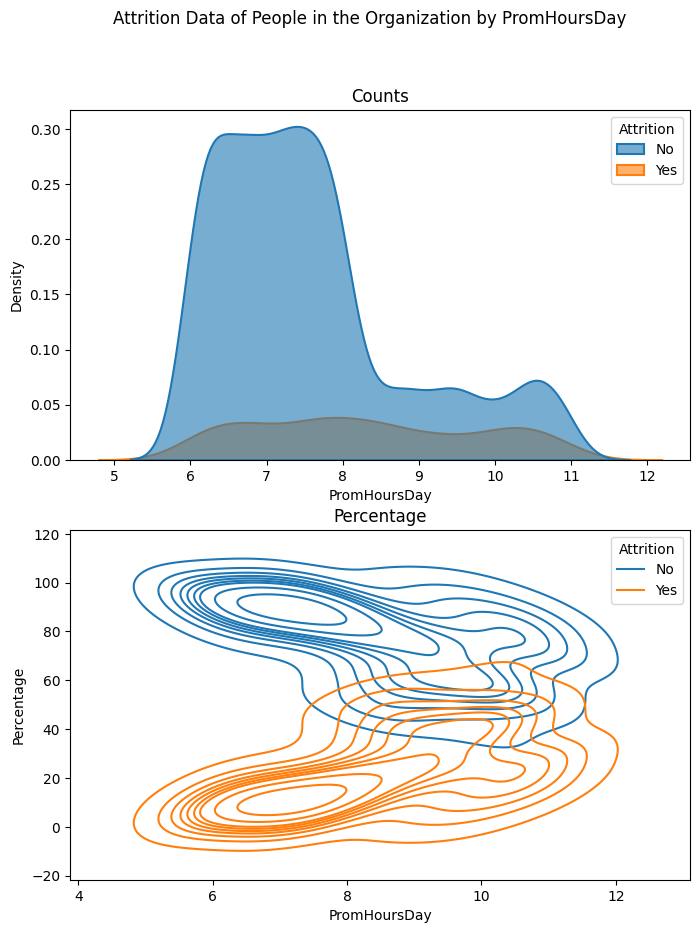

In [ ]:
base_col = "Attrition"
second_col = "PromHoursDay"
data_points = 100
round = 2

plotContinuousValuesKDE(data_analysis_logs, base_col, second_col, data_points, round)

The first chart shows that most employees work an average of 6 to 8 hours daily. The second chart shows that the attrition rate increases as the number of working hours increases, peaking between 10 and 11 hours. This is likely due to employees with a higher workload leaving the company in search of better working conditions.

#### Prom Hours Week

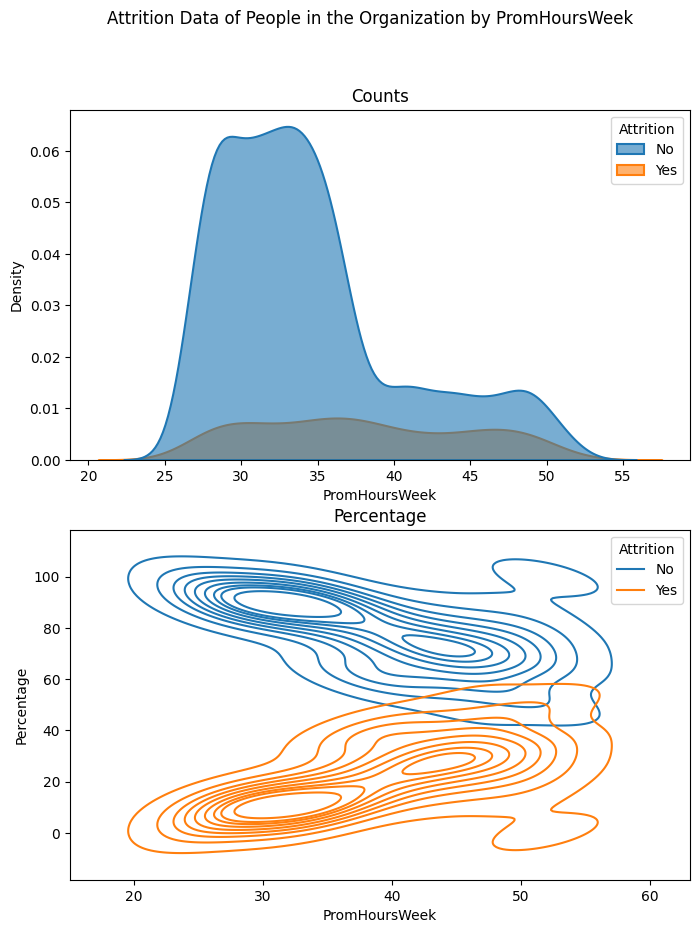

In [ ]:
base_col = "Attrition"
second_col = "PromHoursWeek"
data_points = 100
round = 2

plotContinuousValuesKDE(data_analysis_logs, base_col, second_col, data_points, round)

Both charts behave similarly to the previous ones. The first chart shows that most employees work an average of 28 to 38 hours weekly. The second chart shows that the attrition rate increases as the number of working hours increases.

#### Working Days Out

<ipython-input-14-3431c8b66194>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)
<ipython-input-14-3431c8b66194>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)


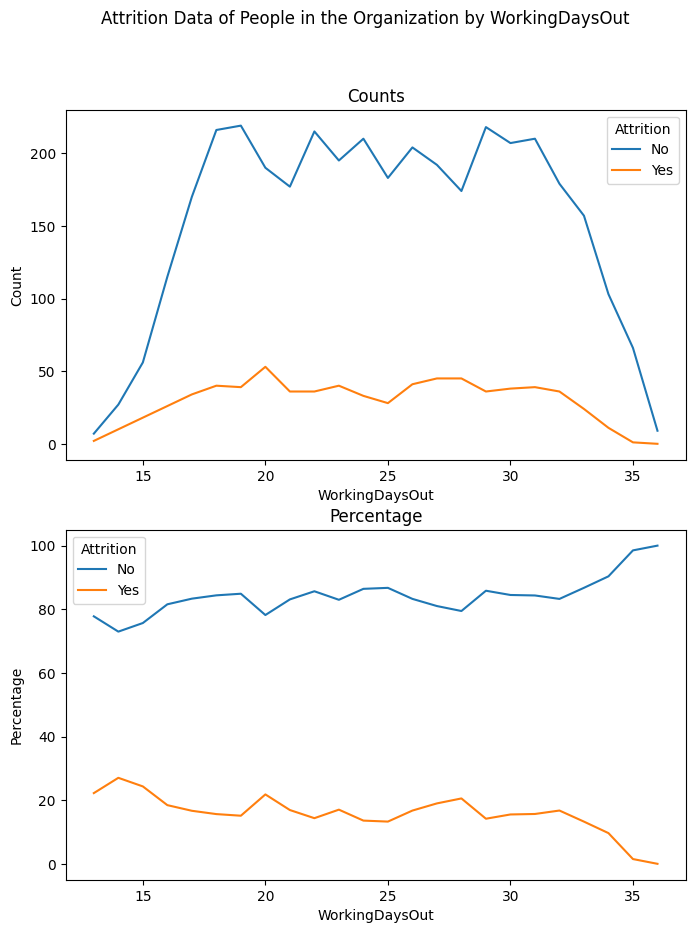

In [ ]:
base_col = "Attrition"
second_col = "WorkingDaysOut"

plotDiscreteValuesLine(data_analysis_logs, base_col, second_col)

The first graph shows that most employees took between 18 and 32 days off during the year. The second graph shows that the rate of sick leave tends to decrease as the number of days off increases, without showing significant peaks, which seems to indicate that employees prefer work environments where they can take frequent breaks and days off.

## Correlation Matrixes

In [ ]:
attrition_encoder = OrdinalEncoder(categories=[['No', 'Yes']])

y_encoded = pd.DataFrame(y.copy())
y_encoded["Attrition"] = attrition_encoder.fit_transform(y_encoded)

### Numerical Data

In [ ]:
data_analysis = X[columns_numerical].merge(y_encoded, on='EmployeeID')

<Axes: >

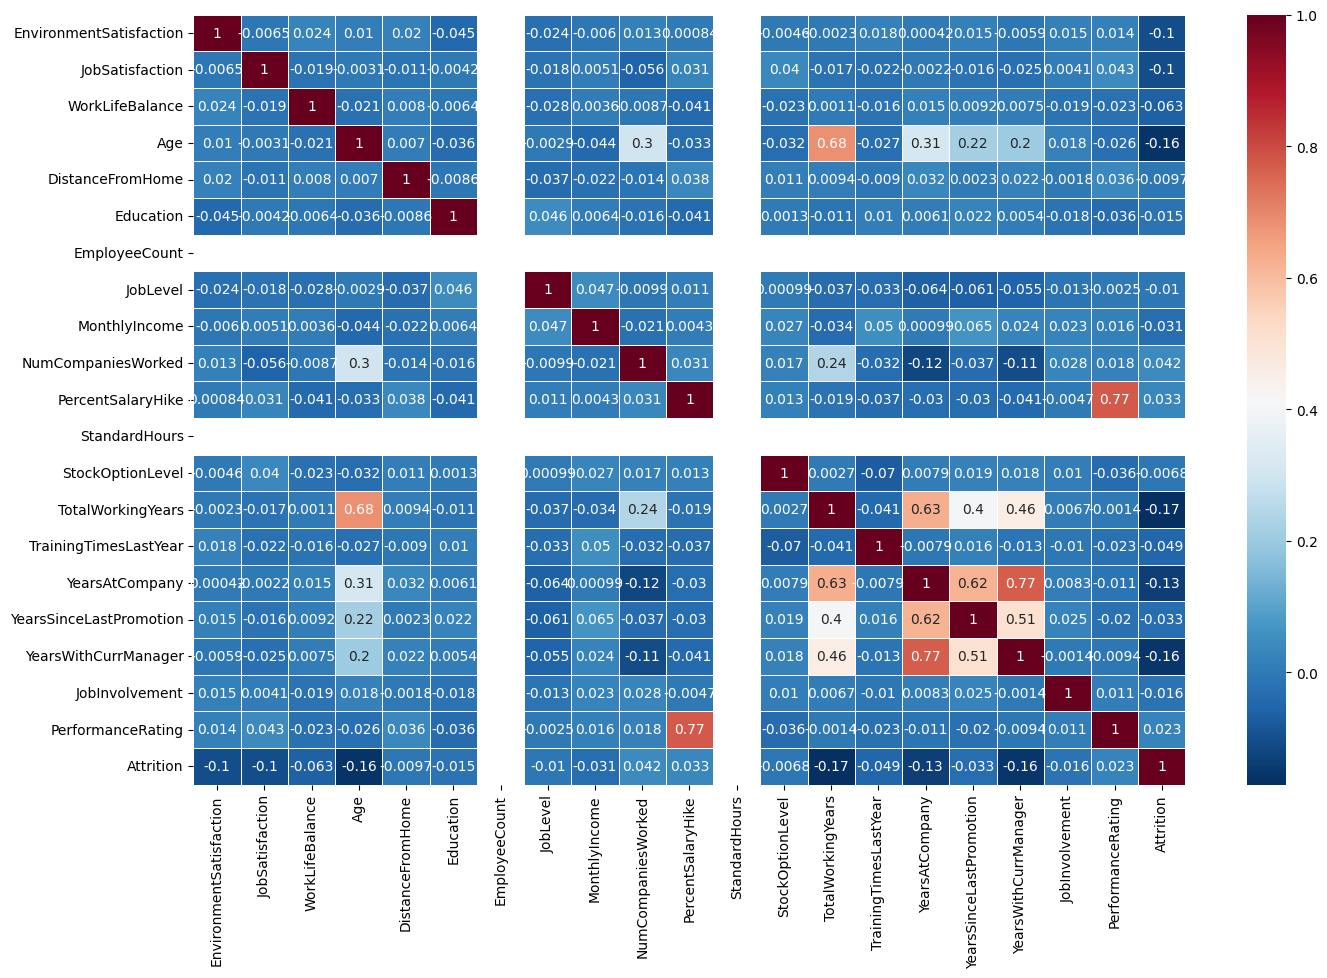

In [ ]:
pearson = data_analysis.corr(method='pearson')
pearson
plt.figure(figsize=(16, 10))
sns.heatmap(pearson,
            xticklabels=pearson.columns,
            yticklabels=pearson.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

### Categorical Data

In [ ]:
categorical_transformer.fit(X[columns_categorical])
categorical_df = categorical_transformer.transform(X[columns_categorical])

In [ ]:
data_analysis = y_encoded.merge(categorical_df, on='EmployeeID')

<Axes: >

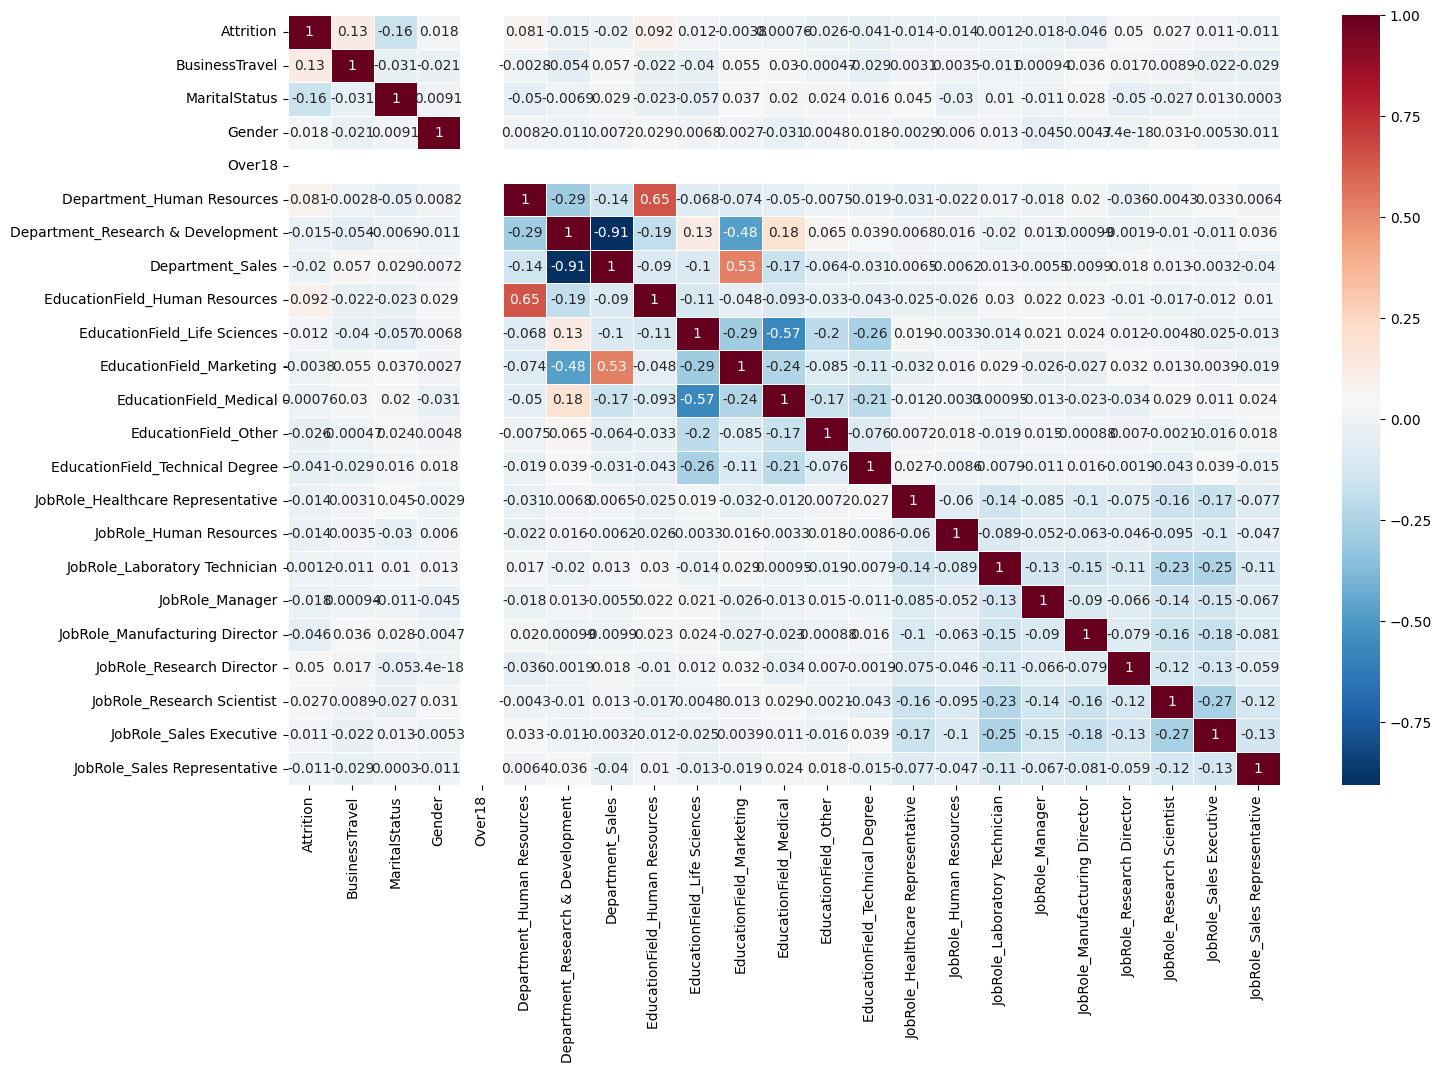

In [ ]:
pearson2 = data_analysis.corr(method='pearson')
pearson2
plt.figure(figsize=(16, 10))
sns.heatmap(pearson2,
            xticklabels=pearson2.columns,
            yticklabels=pearson2.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

### Work Logs Data

In [ ]:
data_analysis = y_encoded.merge(work_logs_data, on='EmployeeID')

<Axes: >

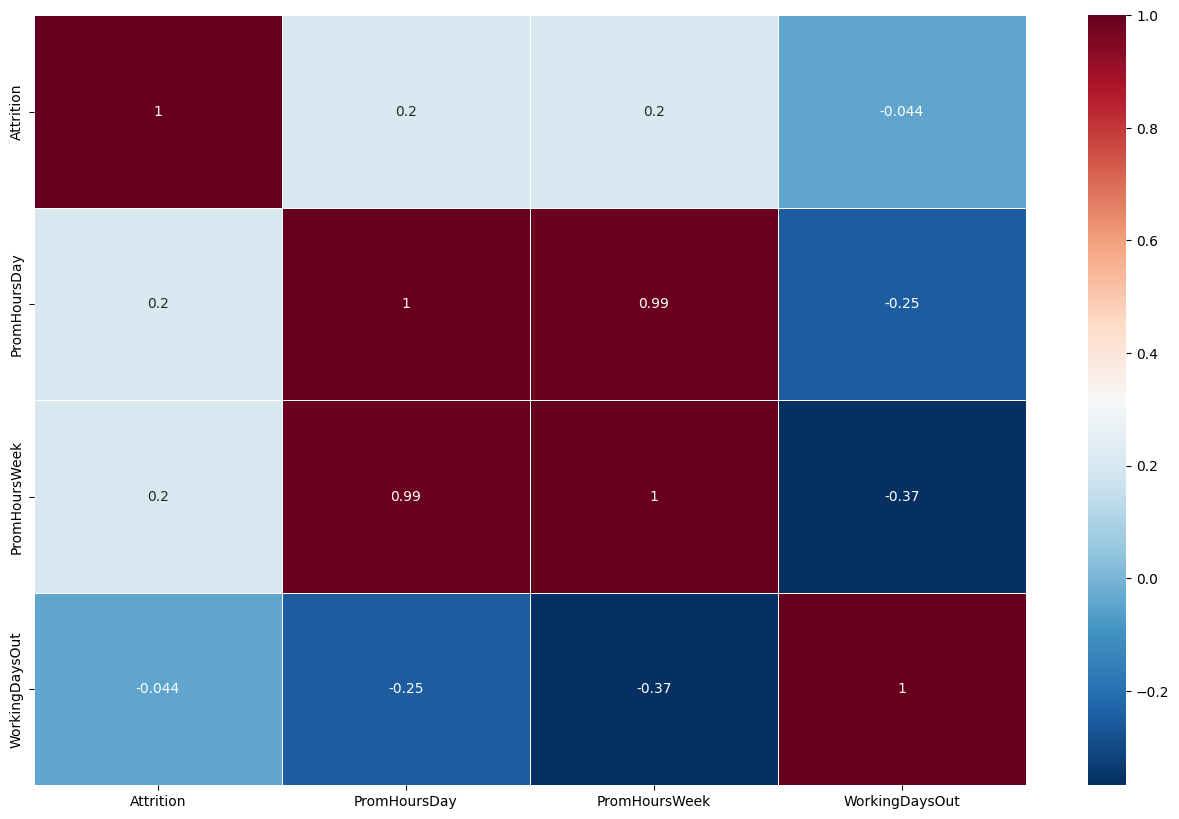

In [ ]:
pearson3 = data_analysis.corr(method='pearson')
pearson3
plt.figure(figsize=(16, 10))
sns.heatmap(pearson3,
            xticklabels=pearson3.columns,
            yticklabels=pearson3.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

### All Data

The above analyses show that some of the variables have a very small value of correlation with attrition. For the following I will ignore the columns that showed less than 2% correlation and did not show important information in the multi-variate analysis.

In [ ]:
data_analysis = y_encoded.merge(X[columns_numerical], on='EmployeeID')
data_analysis = data_analysis.merge(categorical_df, on='EmployeeID')
data_analysis = data_analysis.merge(work_logs_data, on='EmployeeID')

data_analysis = data_analysis.drop(['EmployeeCount', 'StandardHours', 'Over18'], axis=1)

data_analysis = data_analysis.drop(['DistanceFromHome', 'Education', 'JobLevel', 'StockOptionLevel', 'JobInvolvement'], axis=1)

data_analysis = data_analysis.drop(['JobRole_Laboratory Technician', 'EducationField_Marketing', 'EducationField_Medical',
                                    'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Manager',
                                    'JobRole_Sales Executive', 'JobRole_Sales Representative', 'Gender', 'Department_Research & Development',
                                    'EducationField_Life Sciences'], axis=1)

In [ ]:
data_analysis.columns

Index(['Attrition', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'Age', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'PerformanceRating', 'BusinessTravel', 'MaritalStatus',
       'Department_Human Resources', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Other',
       'EducationField_Technical Degree', 'JobRole_Manufacturing Director',
       'JobRole_Research Director', 'JobRole_Research Scientist',
       'PromHoursDay', 'PromHoursWeek', 'WorkingDaysOut'],
      dtype='object')

<Axes: >

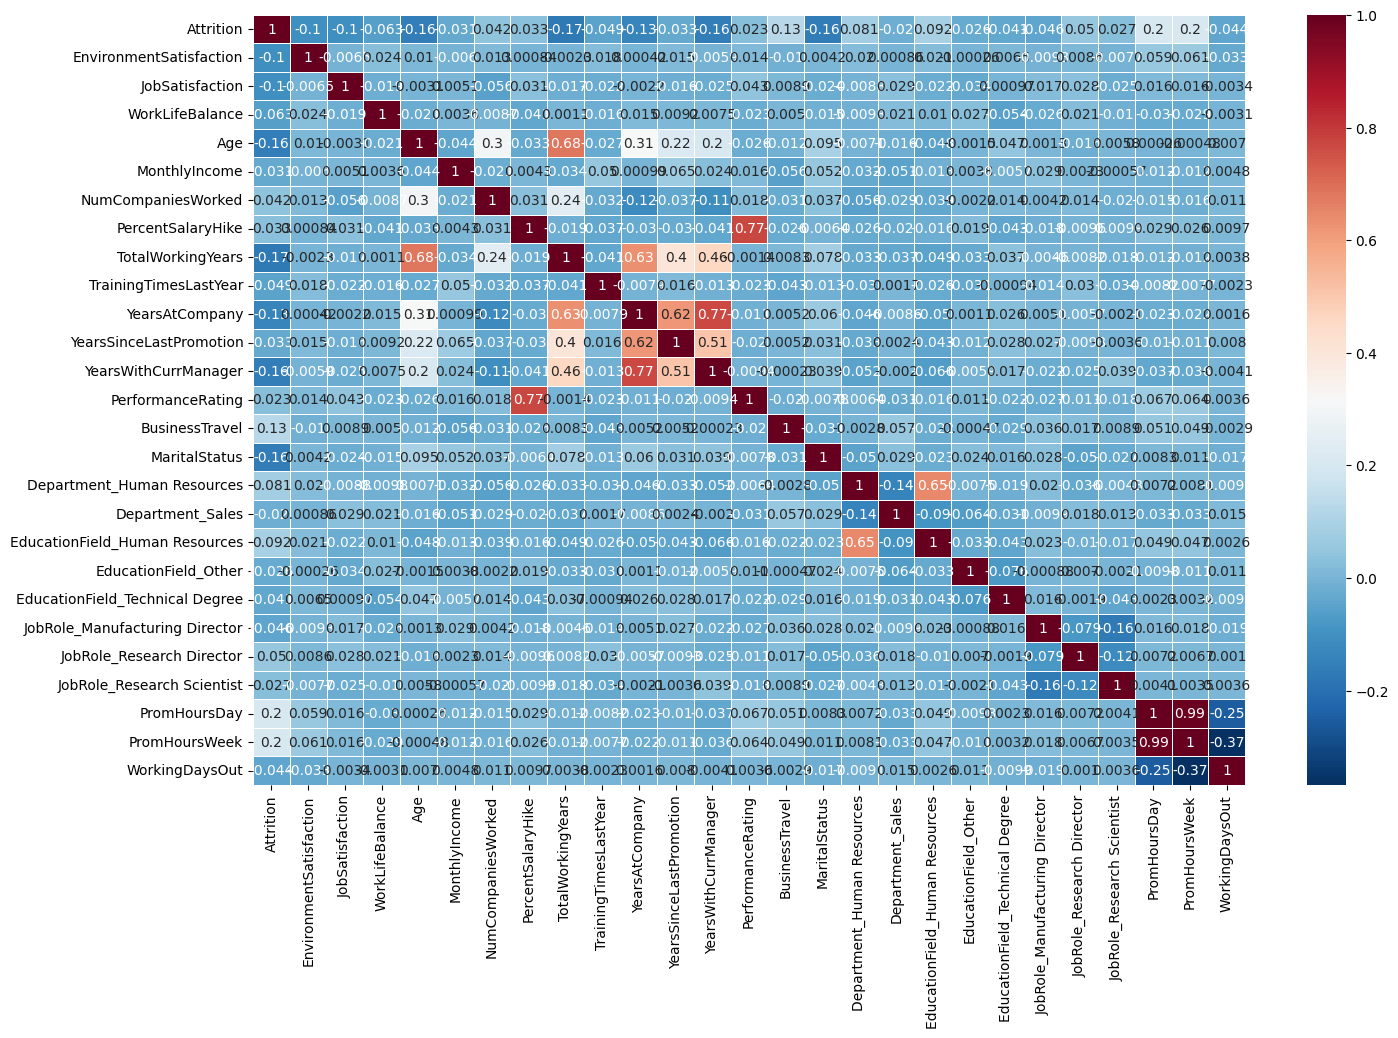

In [ ]:
pearson4 = data_analysis.corr(method='pearson')
pearson4
plt.figure(figsize=(16, 10))
sns.heatmap(pearson4,
            xticklabels=pearson4.columns,
            yticklabels=pearson4.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

The analysis shows that some variables have a high value of correlation between them, so I consider applying a dimensionality reduction to them.